In [12]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# preparing data
from models import *
from methods import *
import pandas as pd
import torch
import os
from os import path
from sklearn.manifold import TSNE

DATASET = 'iiot_data'
"""___________________Hyper Parameters________________________"""
MODEL_NAME = ['AE']
CROSS_VALIDATION_SHUFFLE = True
TRIM_DATA = [False]
FILTER_CORRCOEF = [False]
REMOVE_NOISE = [False]
NOISE_THRESHOLD = [5]
DENOISE = [False]
NOISE_FACTOR = [0.2]
NOISE_FRACTION = [0.2]
PERPLEXITY = 10
NORMALIZE_DATA = [True]
NORMALIZATION_SCHEME = ['standard_scaling']
NORMALIZATION_SCHEME = ['standard_scaling', 'robust_scaling', 'min_max_scaling', 'max_abs_scaling', 'power_transformation_yj', 'quantile_transform_normal']

INITIALIZATION = ['xavier_normal']
ACTIVATION = ['leaky_relu']
SIGMA = [1]
LATENT_DIM = [32]
HIDDEN_DIM = [32]
GD_ALGORITHMS = ['SGD']
WEIGHT_DECAY = [0, 1e-7, 1e-6]
LEARNING_RATE = [1e-4]
BATCH_SIZE = [1024]
EPOCHS = [2000]
ATTENTION = False
"""___________________________________________________________"""
# collapse
# Load Dataset
if DATASET == 'original_data':
    raw_data = np.loadtxt('../data/original_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/original_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'network_data':
    raw_data = np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data':
    raw_data = np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected_cleaned.csv', skiprows=1, delimiter=',')[:,:-1]
    #anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_raw = np.concatenate((np.loadtxt('../data/network_flow_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data1':
    raw_data = np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'medical_data1':
    raw_data = np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/medical1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'full_data1':
    raw_data = np.concatenate((np.loadtxt('../data/network_flow1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
    anomalous_raw = np.concatenate((np.loadtxt('../data/network_flow1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1], np.loadtxt('../data/medical1_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]), axis=1)
elif DATASET == 'network_data2':
    raw_data = np.loadtxt('../data/network_flow2_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/network_flow2_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]
elif DATASET == 'iiot_data':
    raw_data = np.loadtxt('../data/iiot_regular_data.csv', skiprows=1, delimiter=',')[:,:-1]
    anomalous_raw = np.loadtxt('../data/iiot_attack_data.csv', skiprows=1, delimiter=',')[:,:-1]

print(raw_data.shape, anomalous_raw.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
idc = [0,1]
idc = None
if idc:
    raw_data, anomalous_raw = raw_data[:,idc], anomalous_raw[:,idc]
specificity_list, recall_list = [], []

(1107448, 43) (87016, 43)


In [14]:
import itertools

# Different types of model
for model_name in MODEL_NAME:
    # Data Processing
    for trim_data, normalize_data, normalization_scheme, filter_corrcoef, remove_noise, noise_threshold in itertools.product(TRIM_DATA, NORMALIZE_DATA, NORMALIZATION_SCHEME, FILTER_CORRCOEF, REMOVE_NOISE, NOISE_THRESHOLD):
        # initialize containers for data
        loss_array = []
        # process data
        train_X, train_Y, test_X, test_Y = preProcessData_LogisticRegression(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
        #
        train_X, train_Y, test_X, test_Y = toTorchTensor(device, train_X, train_Y, test_X, test_Y)
        criterion = nn.BCELoss(reduction='sum').to(device)
        NUM_FEATURE = train_X.shape[-1]
        attNet = None
        if ATTENTION:
            attNet = AttentionNet(num_feature=NUM_FEATURE, sample_size=len(train_X), E_dim=NUM_FEATURE)
            NUM_FEATURE = attNet.E_Dim
        
        for latent_dim, hidden_dim, activation, initialization, sigma in itertools.product(LATENT_DIM, HIDDEN_DIM, ACTIVATION, INITIALIZATION, SIGMA):
            for algo, learning_rate, weight_decay, epochs, batch_size, noise_factor, noise_fraction in itertools.product(GD_ALGORITHMS, LEARNING_RATE, WEIGHT_DECAY, EPOCHS, BATCH_SIZE, NOISE_FACTOR, NOISE_FRACTION):
                # initialize model
                if model_name == 'AE':
                    model = Discriminator(num_feature=NUM_FEATURE, latent_dim=latent_dim, hidden_dim=hidden_dim, activation=activation, initialization=initialization, logit=True).to(device)
                # train 
                print(train_X.shape, train_Y.shape)
                criterion.reduction = 'sum'
                loss_array = train(model, 'SGD', epochs, train_X, train_Y, criterion, batch_size=batch_size, lr=learning_rate, weight_decay=weight_decay
                    , grad_limit=1e1, att=attNet)
                torch.save(model.state_dict(), '../model/param_AE')
                
                criterion.reduction = 'none'
                if ATTENTION:
                    train_X, test_X = attNet.transformData(train_X), attNet.transformData(test_X)
                    print(torch.diag(attNet.weights))
                
                # test
                y_scores_loss, y_ground_truth = test_classification(model, criterion, test_X, test_Y)
                # plot
                # parameters for visualizer to print
                parameters = {"data_set:":DATASET,
                    "trim_data": trim_data, "normalize_data": normalize_data, "normalization_scheme": normalization_scheme,
                    "filter_corrcoef": filter_corrcoef, "remove_noise": remove_noise, "noise_threshold": noise_threshold,
                    
                    "latent_dim": latent_dim, "hidden_dim": hidden_dim,
                    "activation": activation, "initialization": initialization,

                    "GD algorithm": algo,
                    "weight_decay": weight_decay,
                    "learning_rate": learning_rate,
                    "batch_size": batch_size,
                    "epochs": epochs,
                    "attention": ATTENTION,
                    }
                if model.name == 'VAE':
                    parameters["sigma"] = sigma
                if model.name == 'DAE':
                    parameters["denoise"] = True
                    parameters["noise_factor"] = noise_factor
                    parameters["noise_fraction"] = noise_fraction  
                pred_threshold = 0.5
                ##
                parameters["Train precision"] = torch.sum(torch.logical_and((model(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(model(train_X) > pred_threshold)
                parameters["Train recall"] = torch.sum(torch.logical_and((model(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(train_Y == 1)
                parameters["Test precision"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(model(test_X) > pred_threshold)
                parameters["Test recall"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
                scores = {"y_scores_loss": y_scores_loss}
                visualize_ROC(y_ground_truth, model.name, True, scores, save_path="../graphs/logit/ROC", **parameters)
                # test undetected medical data
                if DATASET == 'medical_data':
                    anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
                    _, _, _, test_X = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data,
                        filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
                    test_X = torch.tensor(test_X).to(torch.float).to(device)
                    test_Y = torch.ones(len(test_X), 1).to(torch.float).to(device)
                    parameters["Undetected data recall"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
                # visualize
                visualize_convergence(loss_array, model.name, save=True, save_path="../graphs/logit/convergence", **parameters)
                plt.close('all')

Train data shape after trim:  (664468, 43)
Train data shape after filter corrcoef:  (664468, 32)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (664468, 32)
torch.Size([955571, 32]) torch.Size([955571, 1])
epoch : 1/2000, loss = 0.419842
epoch : 2/2000, loss = 0.087539
epoch : 3/2000, loss = 0.044523
epoch : 4/2000, loss = 0.037115
epoch : 5/2000, loss = 0.033125
epoch : 6/2000, loss = 0.030932
epoch : 7/2000, loss = 0.029756
epoch : 8/2000, loss = 0.029191
epoch : 9/2000, loss = 0.029017
epoch : 10/2000, loss = 0.028732
epoch : 11/2000, loss = 0.028513
epoch : 12/2000, loss = 0.028351
epoch : 13/2000, loss = 0.028183
epoch : 14/2000, loss = 0.028056
epoch : 15/2000, loss = 0.027937
epoch : 16/2000, loss = 0.027833
epoch : 17/2000, loss = 0.027770
epoch : 18/2000, loss = 0.027671
epoch : 19/2000, loss = 0.027595
epoch : 20/2000, loss = 0.027523
epoch : 21/2000, loss = 0.027423
epoch : 22/2000, loss = 0.027393
epoch : 23/2000, loss = 0.027317
epoch : 24/2000,

KeyboardInterrupt: 

In [ ]:
criterion.reduction = 'none'
if ATTENTION:
    train_X, test_X = attNet.transformData(train_X), attNet.transformData(test_X)
    print(torch.diag(attNet.weights))

# test
y_scores_loss, y_ground_truth = test_classification(model, criterion, test_X, test_Y)
# plot
# parameters for visualizer to print
parameters = {"data_set:":DATASET,
    "trim_data": trim_data, "normalize_data": normalize_data, "normalization_scheme": normalization_scheme,
    "filter_corrcoef": filter_corrcoef, "remove_noise": remove_noise, "noise_threshold": noise_threshold,
    
    "latent_dim": latent_dim, "hidden_dim": hidden_dim,
    "activation": activation, "initialization": initialization,

    "GD algorithm": algo,
    "weight_decay": weight_decay,
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs,
    "attention": ATTENTION,
    }
if model.name == 'VAE':
    parameters["sigma"] = sigma
if model.name == 'DAE':
    parameters["denoise"] = True
    parameters["noise_factor"] = noise_factor
    parameters["noise_fraction"] = noise_fraction  
pred_threshold = 0.7
##
parameters["Train precision"] = torch.sum(torch.logical_and((model(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(model(train_X) > pred_threshold)
parameters["Train recall"] = torch.sum(torch.logical_and((model(train_X) > pred_threshold), (train_Y == 1))) / torch.sum(train_Y == 1)
parameters["Test precision"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(model(test_X) > pred_threshold)
parameters["Test recall"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
scores = {"y_scores_loss": y_scores_loss}
visualize_ROC(y_ground_truth, model.name, True, scores, save_path="../graphs/logit/ROC", **parameters)
# test undetected medical data
if DATASET == 'medical_data':
    anomalous_raw = np.loadtxt('../data/medical_attack_data_undetected.csv', skiprows=1, delimiter=',')[:,:-1]
    _, _, _, test_X = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, trim_threshold=0.98, normalize=normalize_data,
        filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold)
    test_X = torch.tensor(test_X).to(torch.float).to(device)
    test_Y = torch.ones(len(test_X), 1).to(torch.float).to(device)
    parameters["Undetected data recall"] = torch.sum(torch.logical_and((model(test_X) > pred_threshold), (test_Y == 1))) / torch.sum(test_Y == 1)
# visualize
visualize_convergence(loss_array, model.name, save=True, save_path="../graphs/logit/convergence", **parameters)
plt.close('all')

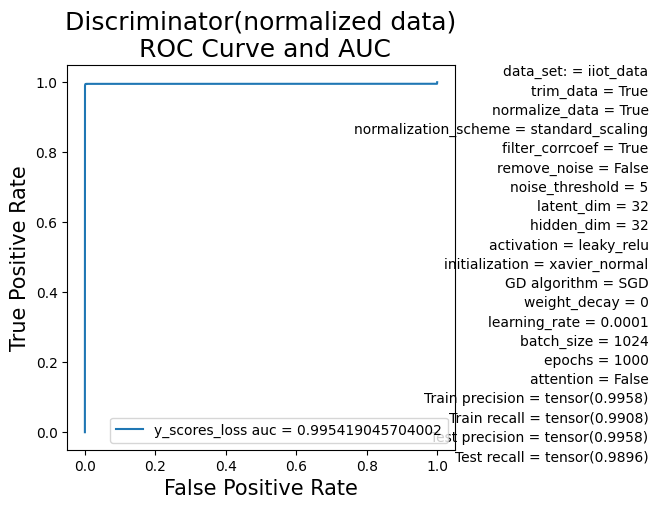

In [ ]:
criterion.reduction = 'none'
y_scores_loss, y_ground_truth = test_classification(model, criterion, test_X, test_Y)
print()
scores = {"y_scores_loss": y_scores_loss}
visualize_ROC(y_ground_truth, model.name, True, scores, save_path="../graphs/logit/ROC", **parameters)


In [ ]:
if ATTENTION:
    print(torch.diag(attNet.weights))
print(parameters)

{'data_set:': 'original_data', 'trim_data': True, 'normalize_data': True, 'normalization_scheme': 'standard_scaling', 'filter_corrcoef': True, 'remove_noise': False, 'noise_threshold': 5, 'latent_dim': 32, 'hidden_dim': 32, 'activation': 'leaky_relu', 'initialization': 'xavier_normal', 'GD algorithm': 'SGD', 'weight_decay': 1e-05, 'learning_rate': 0.0001, 'batch_size': 1024, 'epochs': 10000, 'attention': False, 'Train precision': tensor(0.9572), 'Train recall': tensor(0.7760), 'Test precision': tensor(0.8414), 'Test recall': tensor(0.6452)}
